# Import necessary Modules

In [ ]:
!pip install imagehash
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.models as models
from torchvision.datasets import ImageFolder
import shutil
from tqdm import tqdm
import torch.optim as optim
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import copy
import imagehash
import hashlib
import time
!pip install tqdm


# Mount the Drive to read Files from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# After running this, your Google Drive will be accessible at /content/drive
# You can then navigate to your dataset, for example:
# dataset_path = '/content/drive/MyDrive/Brain tumor dataset'
# train_path = os.path.join(dataset_path, 'train')
# test_path = os.path.join(dataset_path, 'test')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Mention the File paths for Train and Test Directories

In [ ]:
dataset_dir = '/content/drive/MyDrive/brain_tumor_dataset'
train_dir = os.path.join(dataset_dir, 'Training')
test_dir = os.path.join(dataset_dir, 'Testing')

In [ ]:
train_dir

'/content/drive/MyDrive/brain_tumor_dataset/Training'

In [ ]:
image_extensions = ("*.jpg", "*.jpeg", "*.png")

In [ ]:
from glob import glob

# Setup and Scan the Folder into Pandas Dataframe

In [ ]:
def get_image_paths(root_dir, split_name):
    filepaths = []
    class_names = []
    splits = []

    for class_dir in sorted(os.listdir(root_dir)):
        full_class_dir = os.path.join(root_dir, class_dir)
        if not os.path.isdir(full_class_dir):
            continue

        for ext in image_extensions:
            for fp in glob(os.path.join(full_class_dir, ext)):
                filepaths.append(fp)
                class_names.append(class_dir)
                splits.append(split_name)

    return filepaths, class_names, splits

train_paths, train_classes, train_splits = get_image_paths(train_dir, "Training")
test_paths,  test_classes,  test_splits  = get_image_paths(test_dir,  "Testing")

In [ ]:
# Combine into one DataFrame
df = pd.DataFrame({
    "filepath": train_paths + test_paths,
    "class":    train_classes + test_classes,
    "split":    train_splits + test_splits
})

print("Total images:", len(df))
df.head()

Total images: 7045


,filepath,class,split
0,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training
1,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training
2,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training
3,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training
4,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training


#Basic EDA (Class Distribution, Train vs Test)

In [ ]:
print("Split counts:")
print(df["split"].value_counts(), "\n")





Split counts:
split
Training    5734
Testing     1311
Name: count, dtype: int64 



In [ ]:
print("Class distribution (overall):")
print(df["class"].value_counts(), "\n")


Class distribution (overall):
class
notumor       2000
pituitary     1766
meningioma    1645
glioma        1634
Name: count, dtype: int64 



In [ ]:
print("Class distribution by split:")
print(df.groupby(["split", "class"]).size())

Class distribution by split:
split     class     
Testing   glioma         300
          meningioma     306
          notumor        405
          pituitary      300
Training  glioma        1334
          meningioma    1339
          notumor       1595
          pituitary     1466
dtype: int64


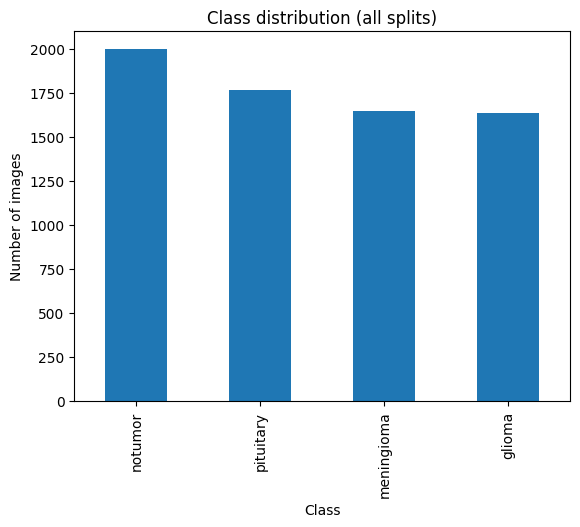

In [ ]:
import matplotlib.pyplot as plt

# Overall distribution
df["class"].value_counts().plot(kind="bar")
plt.title("Class distribution (all splits)")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()




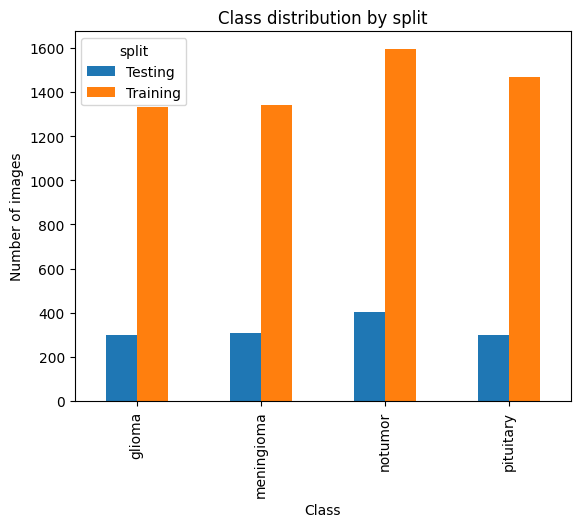

In [ ]:
# Train vs Test distribution
df.groupby(["split", "class"]).size().unstack("split").plot(kind="bar")
plt.title("Class distribution by split")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

# Verifying whether the Images are corrupted or not

In [ ]:
from PIL import Image
from tqdm import tqdm

def is_image_ok(path):
    """
    Returns True if image can be opened & verified.
    Returns False if corrupted or unreadable.
    """
    try:
        with Image.open(path) as img:
            img.verify()     # verify file integrity
        return True
    except Exception:
        return False

# Run check with tqdm progress bar
df["is_ok"] = [
    is_image_ok(fp)
    for fp in tqdm(df["filepath"], desc="Checking images", unit="img")
]

print("Corrupted / unreadable images:", (~df["is_ok"]).sum())
df[~df["is_ok"]].head()



Checking images: 100%|██████████| 7045/7045 [15:36<00:00,  7.52img/s]

Corrupted / unreadable images: 0


,filepath,class,split,is_ok


# Removing Corrupted Images

In [ ]:
df_clean = df[df["is_ok"]].drop(columns=["is_ok"]).reset_index(drop=True)
print("After removing corrupted images:", len(df_clean))


After removing corrupted images: 7045


# Hashing Images so that we can detect Duplicates

In [ ]:
import hashlib
from tqdm import tqdm

def file_md5(path, chunk_size=8192):
    """Return MD5 hash of a file. Returns None if unreadable."""
    md5 = hashlib.md5()
    try:
        with open(path, "rb") as f:
            while True:
                data = f.read(chunk_size)
                if not data:
                    break
                md5.update(data)
        return md5.hexdigest()
    except Exception:
        return None

# Apply hash computation with tqdm
df["hash"] = [
    file_md5(fp)
    for fp in tqdm(df["filepath"], desc="Hashing images", unit="img")
]


Hashing images: 100%|██████████| 7045/7045 [00:20<00:00, 338.24img/s]


# Detecting and removing Unhashable Images (images with None Hash)

In [ ]:
print("Images with None hash:", df["hash"].isna().sum())

df_hashclean = df.dropna(subset=["hash"]).reset_index(drop=True)
print("After removing unhashable images:", len(df_hashclean))


Images with None hash: 0
After removing unhashable images: 7045


# Detecting Duplicate Images via Hashing and removing them

In [ ]:
seen_hashes = set()
duplicate_mask = []

for h in tqdm(df_hashclean["hash"], desc="Detecting duplicates", unit="img"):
    if h in seen_hashes:
        duplicate_mask.append(True)
    else:
        duplicate_mask.append(False)
        seen_hashes.add(h)

df_hashclean["is_duplicate"] = duplicate_mask

print("Number of exact duplicate images:", df_hashclean["is_duplicate"].sum())
df_hashclean[df_hashclean["is_duplicate"]].head()


Detecting duplicates: 100%|██████████| 7045/7045 [00:00<00:00, 1610468.26img/s]

Number of exact duplicate images: 319


,filepath,class,split,is_ok,hash,is_duplicate
58,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,c8d0f3ccff6af6953865e6941cb3eaac,True
97,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,050f57fe301dbbd21b756461ecd83c34,True
102,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,198b6db1eefbc29fc70917d7cfff4a7b,True
186,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,58acdf9a2291765ec0c73c918d795d35,True
191,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,89f113a43bebeba00cc53d9fe656b889,True


## 319 duplicate images removed

# Final cleaned Dataframe

In [ ]:
df_final = df_hashclean[df_hashclean["is_duplicate"] == False].reset_index(drop=True)
print("After removing duplicates:", len(df_final))


After removing duplicates: 6726


# Doing basic EDA on this new Df (duplicate proof)  to check class representation

In [ ]:
print("New class distribution (overall):")
print(df_final["class"].value_counts(), "\n")



New class distribution (overall):
class
pituitary     1740
notumor       1731
meningioma    1635
glioma        1620
Name: count, dtype: int64 



In [ ]:
print("New class distribution by split:")
print(df_final.groupby(["split", "class"]).size())

New class distribution by split:
split     class     
Testing   glioma         299
          meningioma     302
          notumor        309
          pituitary      295
Training  glioma        1321
          meningioma    1333
          notumor       1422
          pituitary     1445
dtype: int64


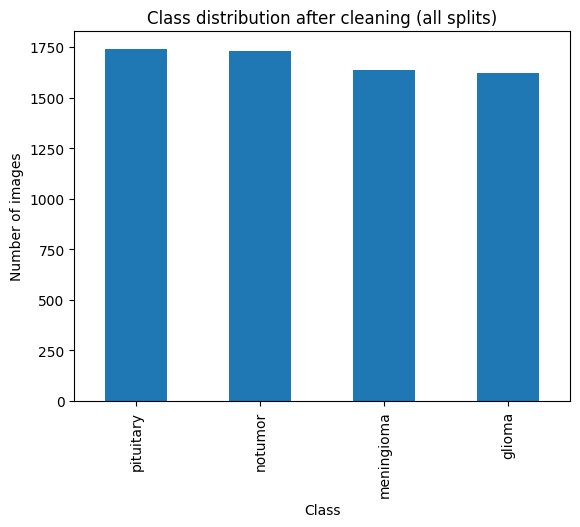

In [ ]:
df_final["class"].value_counts().plot(kind="bar")
plt.title("Class distribution after cleaning (all splits)")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()


# Saving the Final Cleaned Dataframe just for reference purpose

In [ ]:
df_final.to_csv("/content/drive/MyDrive/brain_tumor_dataset/clean_brain_tumor_df.csv", index=False)


# Filter only Train set to do Undersampling on it for equal representation from each of the 4 classes present

In [ ]:
# Filter only train split
train_df = df_final[df_final["split"] == "Training"].copy()

# Count per class
class_counts = train_df["class"].value_counts()
print("Train counts per class:")
print(class_counts)

# Find smallest class size
min_count = class_counts.min()
print("\nUsing min_count =", min_count, "for balanced sampling.")


Train counts per class:
class
pituitary     1445
notumor       1422
meningioma    1333
glioma        1321
Name: count, dtype: int64

Using min_count = 1321 for balanced sampling.


## Purpose of doing Undersampling is that a single class should not get overpowered on other classes during the learning of the Model

# Obtaining the balanced_train_df from train_df after doing Undersampling

In [ ]:
balanced_train_df = (
    train_df
    .groupby("class", group_keys=False)
    .apply(lambda x: x.sample(min_count, random_state=42))
    .reset_index(drop=True)
)

print("\nBalanced train counts per class:")
print(balanced_train_df["class"].value_counts())



Balanced train counts per class:
class
glioma        1321
meningioma    1321
notumor       1321
pituitary     1321
Name: count, dtype: int64


/tmp/ipython-input-3716625826.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_count, random_state=42))


# Plotting the Balanced Train dataframe

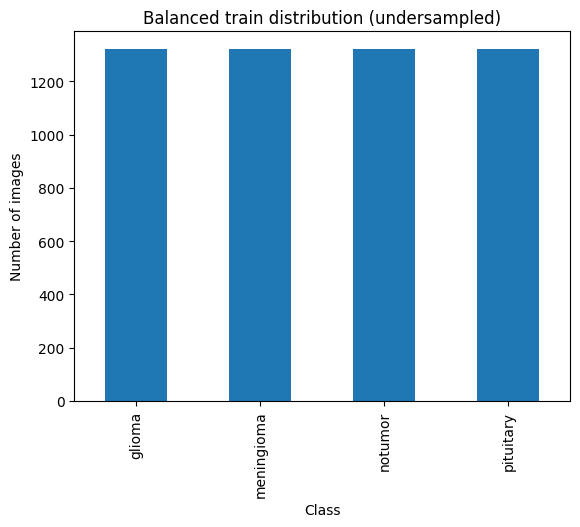

In [ ]:
balanced_train_df["class"].value_counts().plot(kind="bar")
plt.title("Balanced train distribution (undersampled)")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()


At this point:

balanced_train_df = clean, balanced training set (equal images per class)



# We create and save the Train_Balanced_Dataset (equal Images per class) **folder** from the balanced_train_df with images in Drive for further use by the Model in Model.ipynb


In [ ]:
import os
import shutil
from tqdm import tqdm

balanced_train_root = os.path.join(dataset_dir, "train_balanced_dataset")
os.makedirs(balanced_train_root, exist_ok=True)

# Create class subfolders inside train_balanced/
for cls in balanced_train_df["class"].unique():
    os.makedirs(os.path.join(balanced_train_root, cls), exist_ok=True)

print("Creating balanced training directory with symlinks or file copies...")

for _, row in tqdm(balanced_train_df.iterrows(),
                   total=len(balanced_train_df),
                   desc="Processing images",
                   unit="img"):

    src = row["filepath"]
    cls = row["class"]
    dst_dir = os.path.join(balanced_train_root, cls)
    dst = os.path.join(dst_dir, os.path.basename(src))

    # Try to create symlink (best), fallback to copy
    try:
        if not os.path.exists(dst):
            os.symlink(src, dst)
    except OSError:
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

print("Balanced train folder created at:", balanced_train_root)


Creating balanced training directory with symlinks or file copies...


Processing images: 100%|██████████| 5284/5284 [01:27<00:00, 60.39img/s]

Balanced train folder created at: /content/drive/MyDrive/brain_tumor_dataset/train_balanced_dataset


In [ ]:
balanced_train_df

,filepath,class,split,is_ok,hash,is_duplicate
0,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,79e90bfd484ada4ced3494d0e23c462f,False
1,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,8fa586cbbc7f503bd2d39f6fe0643c6d,False
2,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,7f209a50a848b7931afacffa10eada34,False
3,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,03b4852c3db9b34b4a375bf718bd16bc,False
4,/content/drive/MyDrive/brain_tumor_dataset/Tra...,glioma,Training,True,519675fda27bffdd7348b9b3bdf4eaac,False
...,...,...,...,...,...,...
5279,/content/drive/MyDrive/brain_tumor_dataset/Tra...,pituitary,Training,True,c9162fc066dbf2d22eeae1effe4c8ec7,False
5280,/content/drive/MyDrive/brain_tumor_dataset/Tra...,pituitary,Training,True,6d71d5f5b091ad74ae95b44ae641a0a8,False
5281,/content/drive/MyDrive/brain_tumor_dataset/Tra...,pituitary,Training,True,ed61dff9a53f85a35b2b57acb2bb2468,False
5282,/content/drive/MyDrive/brain_tumor_dataset/Tra...,pituitary,Training,True,b612aa0d702020c3dd896f4294000a02,False


# Visualize first 5 images from our balanced train df

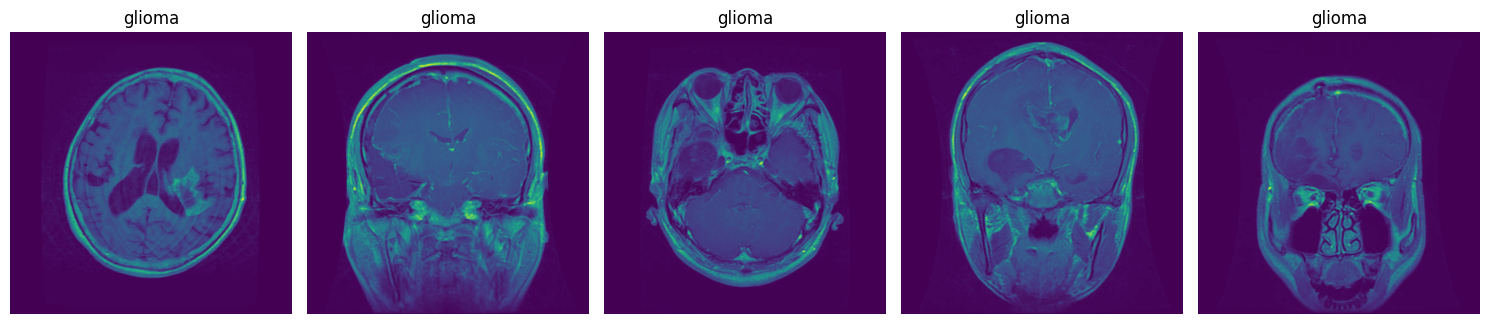

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Show first 5 images
sample_df = balanced_train_df.head(5)

plt.figure(figsize=(15, 8))

for i, row in enumerate(sample_df.iterrows(), 1):
    # row is now a Series, so access columns like a dictionary
    img = Image.open(row[1]["filepath"])
    cls_name = row[1]["class"]

    plt.subplot(1, 5, i)
    plt.imshow(img)
    plt.title(cls_name)
    plt.axis("off")

plt.tight_layout()
plt.show()